#### <b>Load Required Libraries</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 6112 (delta 50), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6112/6112), 647.19 MiB | 25.59 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (5015/5015), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [4]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [5]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [6]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [7]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float)

In [8]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [9]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

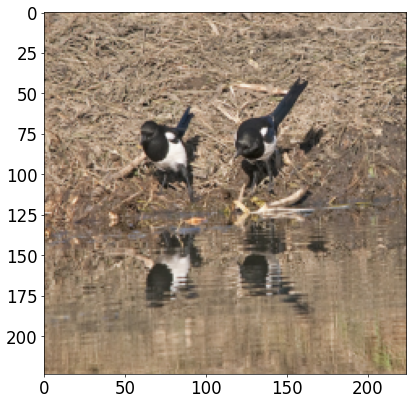

In [10]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [20]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [21]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [22]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


#### <b>Load Validation Dataset</b>

In [23]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Validation dataset size:', len(val_dataset))

class_names = val_dataset.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


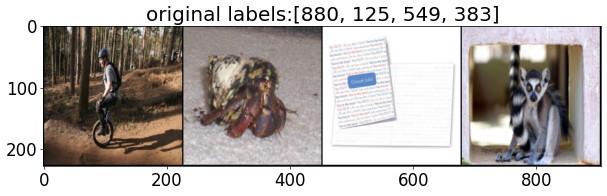

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: unicycle, monocycle (880)
Image #2: hermit crab (125)
Image #3: envelope (549)
Image #4: Madagascar cat, ring-tailed lemur, Lemur catta (383)


In [24]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

[Prediction Result Examples]


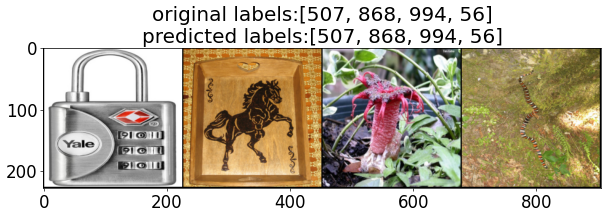

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: combination lock (507)
Image #2: tray (868)
Image #3: stinkhorn, carrion fungus (994)
Image #4: king snake, kingsnake (56)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: combination lock (507)
Image #2: tray (868)
Image #3: stinkhorn, carrion fungus (994)
Image #4: king snake, kingsnake (56)


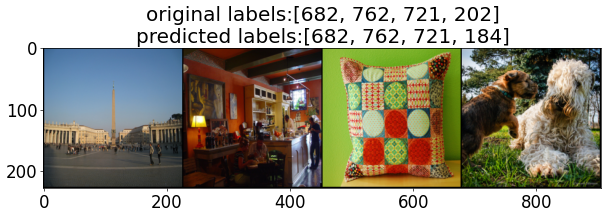

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: obelisk (682)
Image #6: restaurant, eating house, eating place, eatery (762)
Image #7: pillow (721)
Image #8: soft-coated wheaten terrier (202)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: obelisk (682)
Image #6: restaurant, eating house, eating place, eatery (762)
Image #7: pillow (721)
Image #8: Irish terrier (184)
[Validation] Loss: 0.0621 Accuracy: 76.0600% Time elapsed: 34.3626s (total 5000 images)


In [25]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [26]:
!pip install foolbox
!pip install advertorch

In [27]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 100 iterations + Start from the Target (Targeted Attack)
* <b>Images</b>: 5,000 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


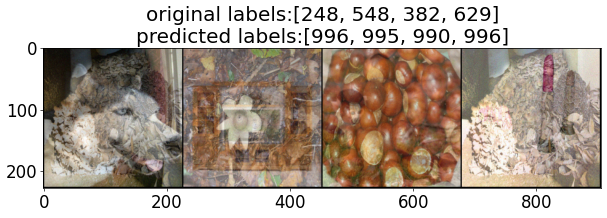

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Eskimo dog, husky (248)
Image #2: entertainment center (548)
Image #3: squirrel monkey, Saimiri sciureus (382)
Image #4: lipstick, lip rouge (629)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)
Image #2: earthstar (995)
Image #3: buckeye, horse chestnut, conker (990)
Image #4: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)


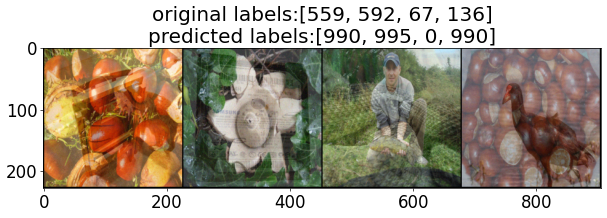

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: folding chair (559)
Image #6: hard disc, hard disk, fixed disk (592)
Image #7: diamondback, diamondback rattlesnake, Crotalus adamanteus (67)
Image #8: European gallinule, Porphyrio porphyrio (136)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: buckeye, horse chestnut, conker (990)
Image #6: earthstar (995)
Image #7: tench, Tinca tinca (0)
Image #8: buckeye, horse chestnut, conker (990)
[Step #0] Loss: 0.5435 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 25.8455s (total 16 images)
[Step #10] Loss: 0.4986 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 233.3906s (total 176 images)
[Step #20] Loss: 0.5197 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 451.9373s (total 336 images)
[Step #30] Loss: 0.5338 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 673.3610s (total 496 images)
[Step #40] Loss: 0.5315 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 888.

In [29]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=100,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
epoch_asr = running_success / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 500 iterations + Start from the Target (Targeted Attack)
* <b>Images</b>: 300 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


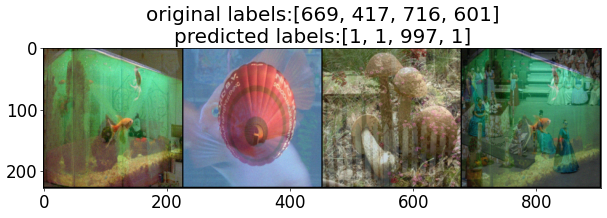

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: mosquito net (669)
Image #2: balloon (417)
Image #3: picket fence, paling (716)
Image #4: hoopskirt, crinoline (601)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: goldfish, Carassius auratus (1)
Image #2: goldfish, Carassius auratus (1)
Image #3: bolete (997)
Image #4: goldfish, Carassius auratus (1)


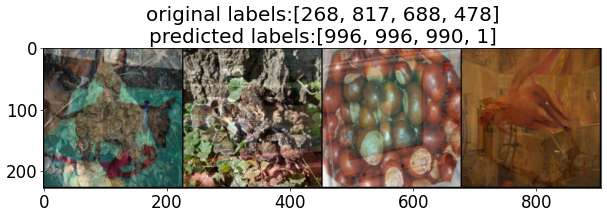

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: Mexican hairless (268)
Image #6: sports car, sport car (817)
Image #7: oscilloscope, scope, cathode-ray oscilloscope, CRO (688)
Image #8: carton (478)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)
Image #6: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)
Image #7: buckeye, horse chestnut, conker (990)
Image #8: goldfish, Carassius auratus (1)
[Step #0] Loss: 0.4202 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 44.4649s (total 16 images)
[Step #10] Loss: 0.4643 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 527.4890s (total 176 images)
[Validation] Loss: 0.4805 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 914.2591s (total 304 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 150517.25657894736
Average L2 distance: 76.84728883442126


In [30]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=500,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 300

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    num_images -= inputs.shape[0]

    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 1000 iterations + Start from the Target (Targeted Attack)
* <b>Images</b>: 300 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


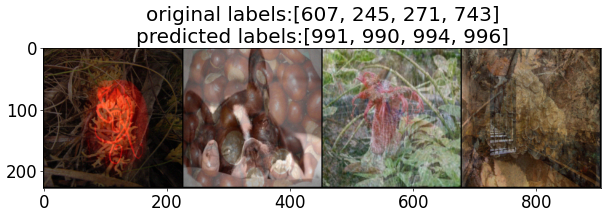

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: jack-o'-lantern (607)
Image #2: French bulldog (245)
Image #3: red wolf, maned wolf, Canis rufus, Canis niger (271)
Image #4: prison, prison house (743)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: coral fungus (991)
Image #2: buckeye, horse chestnut, conker (990)
Image #3: stinkhorn, carrion fungus (994)
Image #4: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)


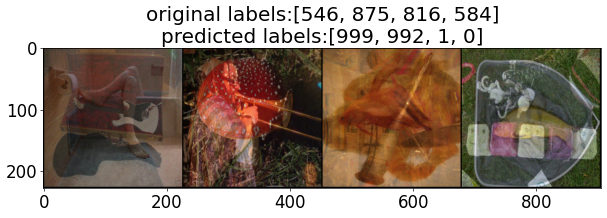

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: electric guitar (546)
Image #6: trombone (875)
Image #7: spindle (816)
Image #8: hair slide (584)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: toilet tissue, toilet paper, bathroom tissue (999)
Image #6: agaric (992)
Image #7: goldfish, Carassius auratus (1)
Image #8: tench, Tinca tinca (0)
[Step #0] Loss: 0.4132 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 81.3359s (total 16 images)
[Step #10] Loss: 0.4036 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 881.9552s (total 176 images)
[Validation] Loss: 0.4256 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1515.3308s (total 304 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 150516.91118421053
Average L2 distance: 74.53847102115029
Average MSE: 0.04044147835750329
Average Linf distance (the maximum changed values): 0.5265155795373415


In [31]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=1000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 300

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    num_images -= inputs.shape[0]

    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 3000 iterations + Start from the Target (Targeted Attack)
* <b>Images</b>: 300 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


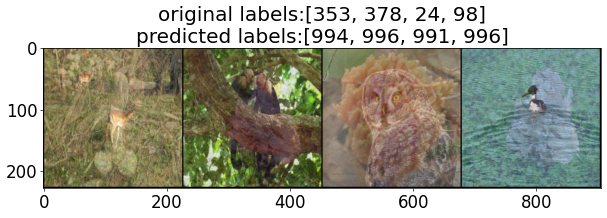

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: gazelle (353)
Image #2: capuchin, ringtail, Cebus capucinus (378)
Image #3: great grey owl, great gray owl, Strix nebulosa (24)
Image #4: red-breasted merganser, Mergus serrator (98)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: stinkhorn, carrion fungus (994)
Image #2: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)
Image #3: coral fungus (991)
Image #4: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa (996)


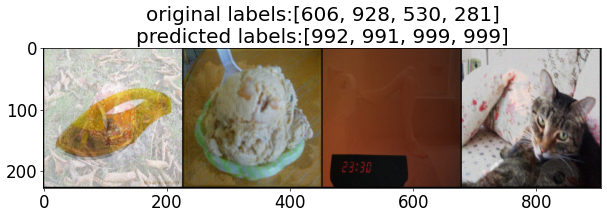

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: iron, smoothing iron (606)
Image #6: ice cream, icecream (928)
Image #7: digital clock (530)
Image #8: tabby, tabby cat (281)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: agaric (992)
Image #6: coral fungus (991)
Image #7: toilet tissue, toilet paper, bathroom tissue (999)
Image #8: toilet tissue, toilet paper, bathroom tissue (999)
[Step #0] Loss: 0.1856 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 200.4725s (total 16 images)
[Step #10] Loss: 0.2830 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 2217.8909s (total 176 images)
[Validation] Loss: 0.2882 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3850.0967s (total 304 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 150512.46710526315
Average L2 distance: 55.04753976119192
Average MSE: 0.022982342952960415
Average Linf distance (the maximum changed values): 0.4164450184295052


In [32]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=3000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 300

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    num_images -= inputs.shape[0]

    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 5000 iterations + Start from the Target (Targeted Attack)
* <b>Images</b>: 300 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


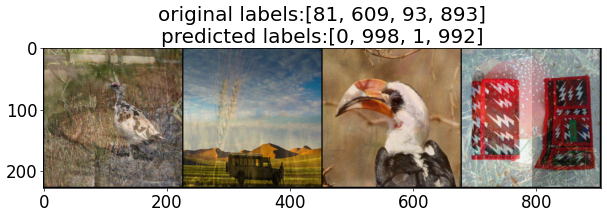

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: ptarmigan (81)
Image #2: jeep, landrover (609)
Image #3: hornbill (93)
Image #4: wallet, billfold, notecase, pocketbook (893)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: tench, Tinca tinca (0)
Image #2: ear, spike, capitulum (998)
Image #3: goldfish, Carassius auratus (1)
Image #4: agaric (992)


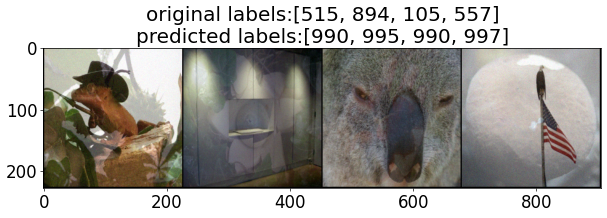

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: cowboy hat, ten-gallon hat (515)
Image #6: wardrobe, closet, press (894)
Image #7: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus (105)
Image #8: flagpole, flagstaff (557)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: buckeye, horse chestnut, conker (990)
Image #6: earthstar (995)
Image #7: buckeye, horse chestnut, conker (990)
Image #8: bolete (997)
[Step #0] Loss: 0.2307 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 334.4769s (total 16 images)
[Step #10] Loss: 0.2213 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3625.3558s (total 176 images)
[Validation] Loss: 0.2323 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 6236.0604s (total 304 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 150521.11513157896
Average L2 distance: 41.62845812345806
Average MSE: 0.013351987214072755
Average Linf distance (the maximum changed v

In [33]:
import time
import random
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=5000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

num_images = 300

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    num_images -= inputs.shape[0]

    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 224, 224).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            starting_points[k], target_labels[k] = val_dataset[random.randint(0, len(val_dataset) - 1)]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

    if num_images <= 0:
        break

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)